In [1]:
%load_ext autoreload
%autoreload 2

# Scalable Recognition with a Vocabulary Tree
---

While we introduce the problem, let's download the data we will use throughout this session. 

In [2]:
!python download.py

data/siftgeo.tar.gz already downloaded in /Users/astanziola/Documents/sberbank/data/siftgeo.tar.gz
data/jpg1.tar.gz already downloaded in /Users/astanziola/Documents/sberbank/data/jpg1.tar.gz
data/jpg2.tar.gz already downloaded in /Users/astanziola/Documents/sberbank/data/jpg2.tar.gz

Data downloaded.
Inflating compressed archives
data/siftgeo.tar.gz already extracted in /Users/astanziola/Documents/sberbank/data/siftgeo
data/jpg1.tar.gz already extracted in /Users/astanziola/Documents/sberbank/data/jpg
data/jpg2.tar.gz already extracted in /Users/astanziola/Documents/sberbank/data/jpg

Extraction completed.


<br>

## **1. Introduction**
---

### 1.1 The image retrieval problem
<hr width=20% align=left>

<img src="images/CBIR.png" height="10" width="400" align="right">


Content-based image retrieval (CBIR) is the process of searching for images in a large database, given a visual query for search. Technically, there are three key components in CBIR:  
  1. Image representation
  2. Database organisation
  3. Image distance measurement



We can further specify the definition of CBIR above.

> CIBR makes use of the ***representation*** of visual content to identify relevant images in a database.


<u>In this lesson we will focus on a **Query-based Image Retrieval** problem, which uses an example image as query.</u>
<br>

> At the end of this session, we expect to be able to have a function as below.  
As we go through the notebook we will learn all the ingredients to implement such function.

In [3]:
def retrieve(database, query):
    raise NotImplemented

<br>
<br>

**In this session we will reproduce and implement the method from the paper that put the grounds for the Google Search from Images:**  
***[Nister, D. and Stewenius, H., 2006, June. Scalable recognition with a vocabulary tree. In 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'06) (Vol. 2, pp. 2161-2168). Ieee.](https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/bioengineering/public/directions/Directions-to-Bessemer-Level-4-Meeting-Rooms-1-and-2.pdf)***


### 1.2 CBIR pipeline
<hr width=20% align=left>
We can distinguish two main stages in a CBIR framework: an **offline** stage, and an **online** stage [ref]. These stages constitute the high-level architecture; individual components would make use of a mixture of techniques (including, for example, supervised and unsupervised learning).

<div style="img {align: left}">
<img src="images/pipeline_extended.png">
<em>Image from Zheng et al 2017. "SIFT meets CNN: A decade survey of instance retrieval."</em>
</div>

The objective of the **offline** stage is to use the image stack to build an indexed database. We tend to concentrate most of the computational effort in this stage of creation, to ease, instead, the online stage.
It is concerned with two main operations:
- Create a representation of the images
- Efficiently index the images 



Given a *query* image, the objective of the **online** stage is to score part (or all) of the images in the database, and return the ones with the higest scores.



This is how we would implement a CBIR model.  
We will divide the CBIR into different functionalities and address each functional block as we go through the notebook. In the last part of the session, we will put everything together.

In [4]:
class CBIR:
    def __init__(self, dataset):
        self.dataset = dataset
        self.database = None  # we haven't built an indexed database yet
        return
    
    #-- TASK 1
    def find_keypoints(self, image):
        # Implement me using MSER, please
        raise NotImplemented
        
    #-- TASK 2
    def extract_features(self, image):
        # Implement me using SIFT, please
        raise NotImplemented
    
    #-- TASK 3
    def create_vocabulary(self, image):
        # Implement me using extract_features and BOW, please
        raise NotImplemented

    #-- TASK 4
    def encode(self, dataset):
        # Implement me using vocabulary tree, please
        raise NotImplemented
    
    #-- TASK 5
    def score(self, image):
        raise NotImplemented
    
    #-- TASK 6
    def retrieve(self, query):
        # this is the function we have described above
        raise NotImplemented

<br>

## **2. Features Extraction**


### 2.1 Find keypoints
<hr width=20% align=left>

<div style="margin:auto; float:right; margin-left: 50px; width: 45%">
<img src="images/features_extraction_only.jpeg">
<em>Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference Add image caption with reference</em>
</div>

<p style="color: #a00; font-weight: 700">>> TASK 1</p>

> In this section we are going to learn how to implement the function:
```python
def find_keypoints(self, image):
    raise features
```
which extract a set of keypoints later used to describe the image.

Keypoints can be thought of as **landmarks** in a scene. Similar to the intuitive "human" notion of landmarks, keypoints are distinctive locations in space. Unlike what humans treat as a landmark, they can be computed
directly from image data, based on the principle that landmarks should be relatively sparse, distinctive, and stable. Once landmarks have been found, they can be used as reference points around which to build descriptions of surrounding image structure.

We will implement feature extraction using the [Scale Invariant Feature Transform (SIFT)](https://link.springer.com/content/pdf/10.1023/B:VISI.0000029664.99615.94.pdf) method. SIFT is an image descriptor for image-based matching and recognition developed by David Lowe (1999, 2004). This descriptor, as well as related image descriptors, are used for a large number of purposes in computer vision for point matching between different views of a 3-D scene, and view-based object recognition. The SIFT descriptor is approximately invariant to translations, rotations and scaling transformations in the image domain and robust to moderate perspective transformations and illumination variations.[ref]

#### Manipulating images

To perform fast manipulations on the images, we will use the [open-cv library](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html). We start by importing it, together with the `numpy` library and the `matplotlib` library for image plotting.

We also call some functions that take care of handling our image dataset, manipulating and showing our images, and showing the landmark points that we are going to detect.

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from features import Descriptor
from dataset import Dataset

# Loading the dataset
dataset = Dataset()
descriptor = Descriptor()

Let's look at a random image from the dataset:

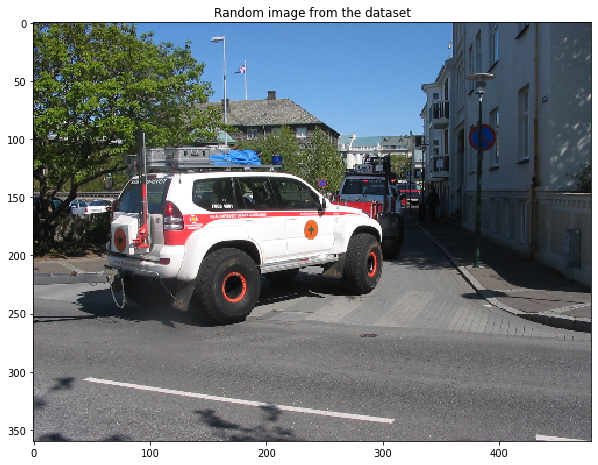

In [6]:
img = dataset.get_random_image()

# Plotting the image
plt.figure(figsize=(10,10))
dataset.show_image(img)
plt.title("Random image from the dataset")
plt.show()

### Corner detector 

A possible set of interesting points is given by the corners of the objects in the image. We will use the Corner detector operator developed by [Harris and Stephens](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html), to extract them from the image.

Let's start by loading an image with well defined corners. We will load it in grayscale.
We can also freely manipulate the image using `numpy`, as in the following example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


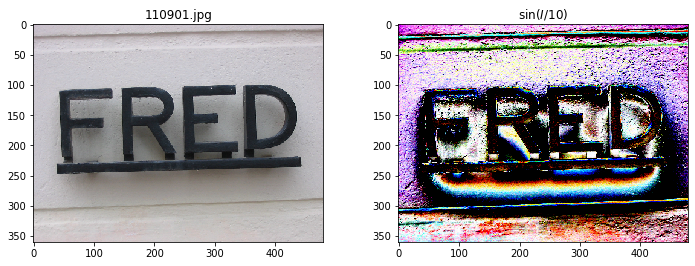

In [101]:
# Loading and displaying an image
img = dataset.get_image_by_name('110901.jpg')
z = np.sin(img/10.)

# Plotting functions
plt.figure(figsize=(12,4))
plt.subplot(121)
dataset.show_image(img, gray=True)
plt.title('110901.jpg')
plt.subplot(122)
dataset.show_image(z, gray=True)
plt.title("$\sin(I/10)$")
plt.show()

The opencv implementation of the detector is found in `cv2.cornerHarris()` ([here is the documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris#cornerharris)). You can try to tune the parameters of the function to improve your corner detection. You are also invited to experiment with different pitcures

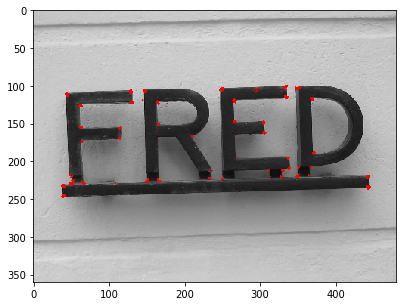

In [106]:
# Compare to OpenCV implementation   
gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
dst = cv2.cornerHarris(gray,blockSize=3,ksize=11,k=0.01)
treshold = 0.01
dst = dst > treshold*dst.max()

plt.figure(figsize=(7,5))
descriptor.show_corners_on_image(gray,dst)

#### Better keypoint detectors

Clearly, corners are not the only interesting locations of an image: one could argue that the letters F-R-E-D are much more important features in the picture above. This calls for more general and sofisticate keypoints detectors.

To build our database, we will use the [Maximally stable extremal region extractor (MSER)](https://docs.opencv.org/3.4/d3/d28/classcv_1_1MSER.html), which is roboust against many transformations such as scaling, rotations, photometric transformations etc.

The following code sets up a MSER detector function which you can test on different images. Now one could use this function on the entire dataset, building a list of interesting keypoints for each image.

In [145]:
# The key function to implement (they can tweak the parameters quite a bit)
def find_keypoints(image):
    # Creating the detector and setting some properties
    orb = cv2.ORB.create(1500, nlevels=32)
    
    # Detecting the keypoints
    kp = orb.detect(image)
    return kp, []#coordinates

We now have a function to detect the keypoints, together with their scale. Let's load a function that visualizes the  keypoints and try it on `FRED`!

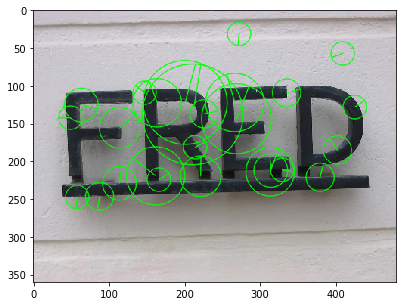

In [146]:
img = dataset.get_image_by_name('110901.jpg')

keypoints, blobs = find_keypoints(img)

plt.figure(figsize=(15,5))
img2 = cv2.drawKeypoints(img, keypoints[::30], None, color=(0,255,0), flags=4)
dataset.show_image(img2)

We can check some of the extracted patches too

You can also try it on different images and modify its implementation / parameters to see how the results are affected

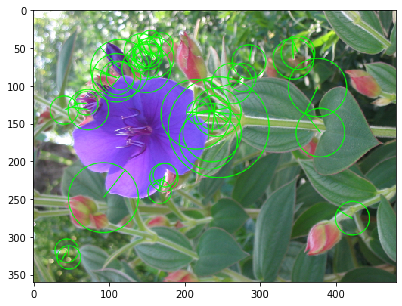

In [147]:
# Try on a random image of the dataset
img = dataset.get_random_image()

keypoints, blobs = find_keypoints(img)

plt.figure(figsize=(15,5))
img2 = cv2.drawKeypoints(img, keypoints[::30], None, color=(0,255,0), flags=4)
dataset.show_image(img2)

<br>
<br>

**2.2 Extract local features**  
<hr width=20% align=left>
<div style="margin: auto; float: left; margin-right: 50px; width: 19%">
<img src="images/bow.png">
<em>Add image caption with reference</em>
</div>



On the other hand, we will implement the "Bag of visual words" model [ref]. It borrows the "bag of words" concept from the natural language processing field, and implements a visual surrogate.

<div style="margin-left: 230px">
<br>
    
    
<p style="color: #a00; font-weight: 700">>> TASK 2</p>
    
> In this section we are going to learn how to implement the function:
```python
def extract_descriptors(self, image):
    return embedding
```
</div>

In CBIR an image is transformed to some kind of feature space. The motivation is to achieve an implicit alignment so as to eliminate the impact of background and potential transformations or changes while keeping the intrinsic visual content distinguishable. [ref]


Once we have obtained the features of an image, ee will implement the "Bag of visual words" model [ref]. It borrows the cocept of "bag of words" from the natural language processing field, and implements its visual correspondent.

In [149]:
def extract_descriptors(image, keypoints):
    orb = cv2.ORB.create(1500, nlevels=32)
    features = orb.compute(image, keypoints)
    return sift

You can try the function by looking at the first **5** descriptors extracted by the algorithm

In [151]:
img = dataset.get_image_by_name('131500.jpg')

keypoints, blobs = find_keypoints(img)
sift = extract_descriptors(img, keypoints)

print("Descriptor for the 1st feature:\n {}".format(sift[0]))
print(sift.shape)

Descriptor for the 1st feature:
 [ 77.  85.  29. 101.  48.  14. 111. 184. 116. 170. 122. 100. 215.  51.
 129. 113.  22.  84.  92. 110. 233. 176.  89.  14. 228. 175.  37. 132.
 104. 243.  66.  33.]
(500, 32)


Now that we are able to extract some descriptors from the keypoints in the image, let's visualize some of them

In [157]:
img = dataset.get_image_by_name('131500.jpg')
keypoints, blobs = find_keypoints(img)
patches = descriptor.extract_patches(img, keypoints)
sift = descriptor.extract_features(np.array(gray_patches))

descriptor.show_random_descriptors(img, patches, sift)

TypeError: Expected Ptr<cv::UMat> for argument 'array'

Of course we can try this on random images too

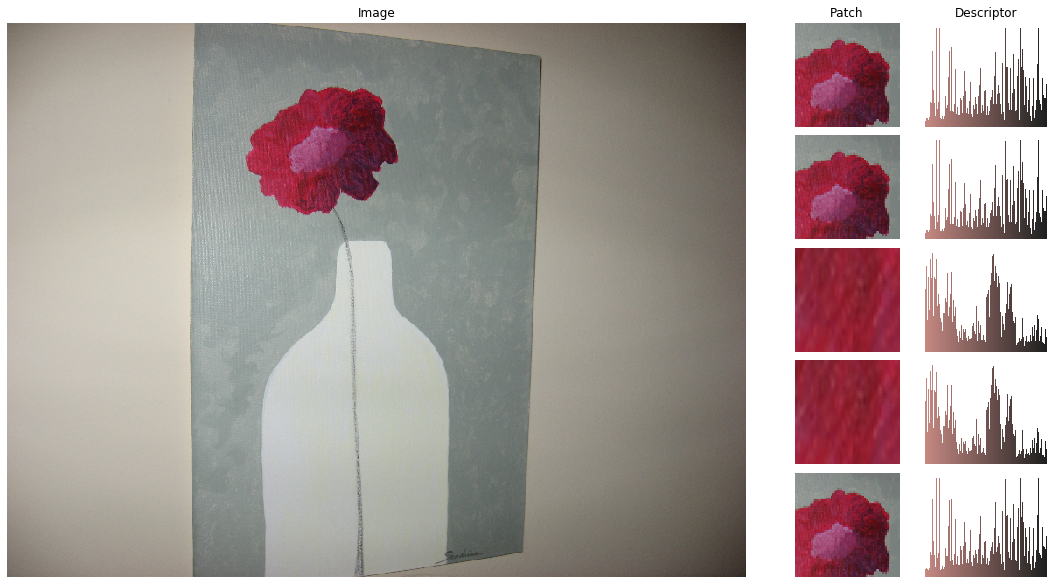

In [17]:
img = dataset.get_random_image()
keypoints, blobs = find_keypoints(img)
bboxes = descriptor.fit_bounding_box_to_mser(blobs)
patches = descriptor.extract_patches(img, bboxes)
gray_patches = [cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) for x in patches]
sift = descriptor.extract_features(np.array(gray_patches))


descriptor.show_random_descriptors(img, patches, sift)

<br>

## **Chapter 3: Creating a visual vocabulary**
---

<br>
    <b>Why using the vocabulary?</b><br>
Image retrieval works very well when you have a very large codebook. The codebook is the set of all the features extracted from the available data.

However, having large codebooks is unfeasible because **non-vocabulary methods do not scale well**.
Let's see why.

We have a feature, ***q***, and a list of database features ***D***.
<u>The objective is to find the feature ***d<sub>i</sub>*** in the database, that is closed to the query feature ***q***.</u>
We consider two cases:
- A flat list
- A hierarchical tree

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 43%;">
    <center>Case 1: A flat list. You can think of this as a tree with only <code>l = 1</code> levels, and <code>k = 27</code> branches.</center>
    <center>To find the closest element in the database you perform <code>27</code> comparisons, because you compare the query feature <i><b>q</b></i> directly with all the 27 database feature <i><b>d<sub>i</sub></b></i></center>
    <br>
<img src="images/flat_list.png">
    <center>\begin{align}k^l\end{align}</center>
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 48%;">
    <center>Case 1: A tree with <code>l = 3</code> levels, and <code>k = 3</code> branches.</center>
    <center>The find the closest element in the database you perform <code>9</code> comparisons, because you compare the query feature <i><b>q</b></i> with the first <code>k = 3</code> virtual elements, up to <code>l = 3</code> levels down.</center>
<img src="images/tree_27.png">
<center>\begin{align}k * l\end{align}</center>
</div>

<br>

The most important contribution of the paper we implement is
an **indexing mechanism** that enables extremely efficient
retrieval.

It proposes a **hierarchical TF-IDF** scoring using
hierarchically defined visual words that form a vocabulary
tree.   
This allows much more efficient lookup of visual
words, which enables the use of a larger vocabulary, which
is shown to result in a significant improvement of retrieval
quality.


<div style="margin:auto; float:right; margin-left: 50px; width: 60%">
<!--     <center>How we construct this vector is key for the retrieval performance</b></center> -->

<img src="images/tree_structure.png">
    <center>
    <b><i>The tree directly defines the visual vocabulary
    and an efficient search procedure in an integrated
        manner.</b></i>
    </center>
</div>
<br>
    
<p style="color: #a00; font-weight: 700">>> TASK 3</p>

> In this section we are going to learn how to implement the function:

```python
# >> TASK 3
def create_vocabulary(features):
    # Implement me using Hierarchical kmeans
    # return the tree and the index
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses Hierarchical KMeans to build the tree, and Term Frequency-Inverse Document Frequency to index each sample of the database.

<br>  
<center>

> ***Recipe:***   
> ***2.1.*** Building the tree using hierarchical k-means   
> ***2.2*** ***Indexing*** the database using TF-IDF (Term Frequency-Inverse Document Frequency)   
> ***2.3*** ***Scoring*** two images   
> ***2.4*** ***Retrieving*** similar images   

<br>

### 3.1 Building the tree using hierarchical k-means
---

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 33%;">
<img src="images/kmeans.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>

In this section we are going to hierarchically separate the features into clusters using ***hierarchical k-means***.

`k` defines the branch factor (number of
children of each node) of the tree. First, an initial k-
means process is run on the training data, defining k cluster
centers. The training data is then partitioned into k groups,
where each group consists of the descriptor vectors closest
to a particular cluster center.

The procedure is applied recursively on each of the clusters, until we reach a depth `L`.


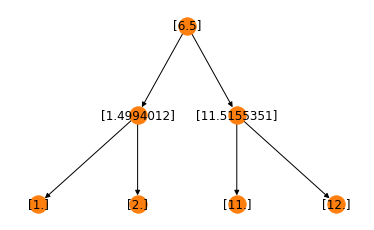

In [158]:
from cbir import CBIR
import numpy as np

# initialise the database
database = CBIR("data/jpg", n_branches=2, depth=2, sift_implementation="pytorch")

# perform hierarchical k-means clustering on the features
features = np.array([[1.], [2.], [11.], [12.]])
database.fit(features)

# plot the graph
fig = database.draw(labels=database.nodes, figsize=(5, 3), node_color="C1")

- The internal nodes of the tree are the cluster centers
- The leaves of the node are the features we started from



Try it out with your own features now. Remember:
- `n_branches` controls how many nodes to create from a parent node (`k` in the picture above)
- `depth` controls the number of levels in the tree (`L` in the picture above)

In [159]:
n_branches = 2
depth = 4

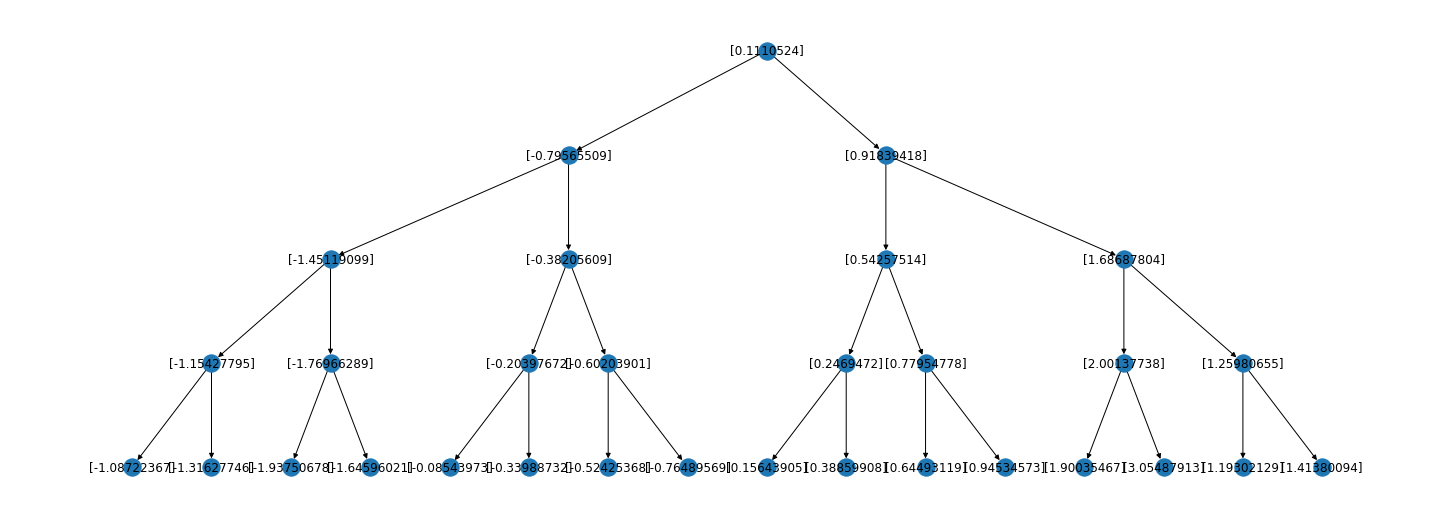

In [160]:
# initialise the database
database = CBIR("data/jpg", n_branches=n_branches, depth=depth)

# perform hierarchical k-means clustering on the features
database.fit(np.random.randn(100, 1))

# plot the graph
fig = database.draw(figsize=(20, 7), labels=database.nodes)

<br> 

### 3.2 Indexing the database using TF-IDF (Term Frequency-Inverse Document Frequency)
---

<div style="margin:auto; float:right; margin-roght: 50px; width: 40%">
<img src="images/index.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>


Indexing is the process of building and storing a **database table** to perform efficient **lookups**, i.e. to quickly find a specific database element.  
In the image retrieval problem we store an index that associates an image, with its vector representation: **`image: vector`**



<p style="color: #a00; font-weight: 700">>> TASK 4</p>

> In this section we are going to learn how to implement the function:
```python
def encode(dataset):
    return indexed_database
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses inverted indices and hierarchical k-means to build the graph.

> ***Recipe:***  
> 1. Given an image, for each feature, we propagate the feature down the tree.   
> 2. We start from the root of the tree, and find the closest node among its children nodes.  
> 3. We apply the same procedure until we reach the bottom of the tree, a leaf.  
> 4. Every time we pass through a node, we register the passage by adding +1 to the node, for that specific image.  

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 45%;">
    <center>
    <b>Feature #1</b>
        <br>
    </center>
<img src="images/encoded_a.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 45%;">
    <center>
    <b>Feature #2</b>
        <br>
    </center>
<img src="images/encoded_b.png">
</div>
<br>
<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 45%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #3</b>
    </center>
<img src="images/encoded_c.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 45%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #4</b>
    </center>
<img src="images/encoded_d.png">
</div>

<!-- <em>Add image caption with reference</em> -->
</div>
<br>

<div style="margin:auto; float:center; width: 55%;">
    <br>
    <center>
        When we have propagated all the features, we count the number of passages at each node.     
        <b>This represents our encoded image</b>    
    </center>
    <img src="images/encoded_all.png">
</div>
 

This results into a tf-idf scheme: when we cross a node, we leave a fingerprint on the node:

In [161]:
# let's take a look at how we can encode an image
image_id = "142000"

Image as perceived by us:


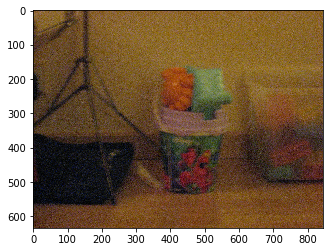

Image embedding as graph:


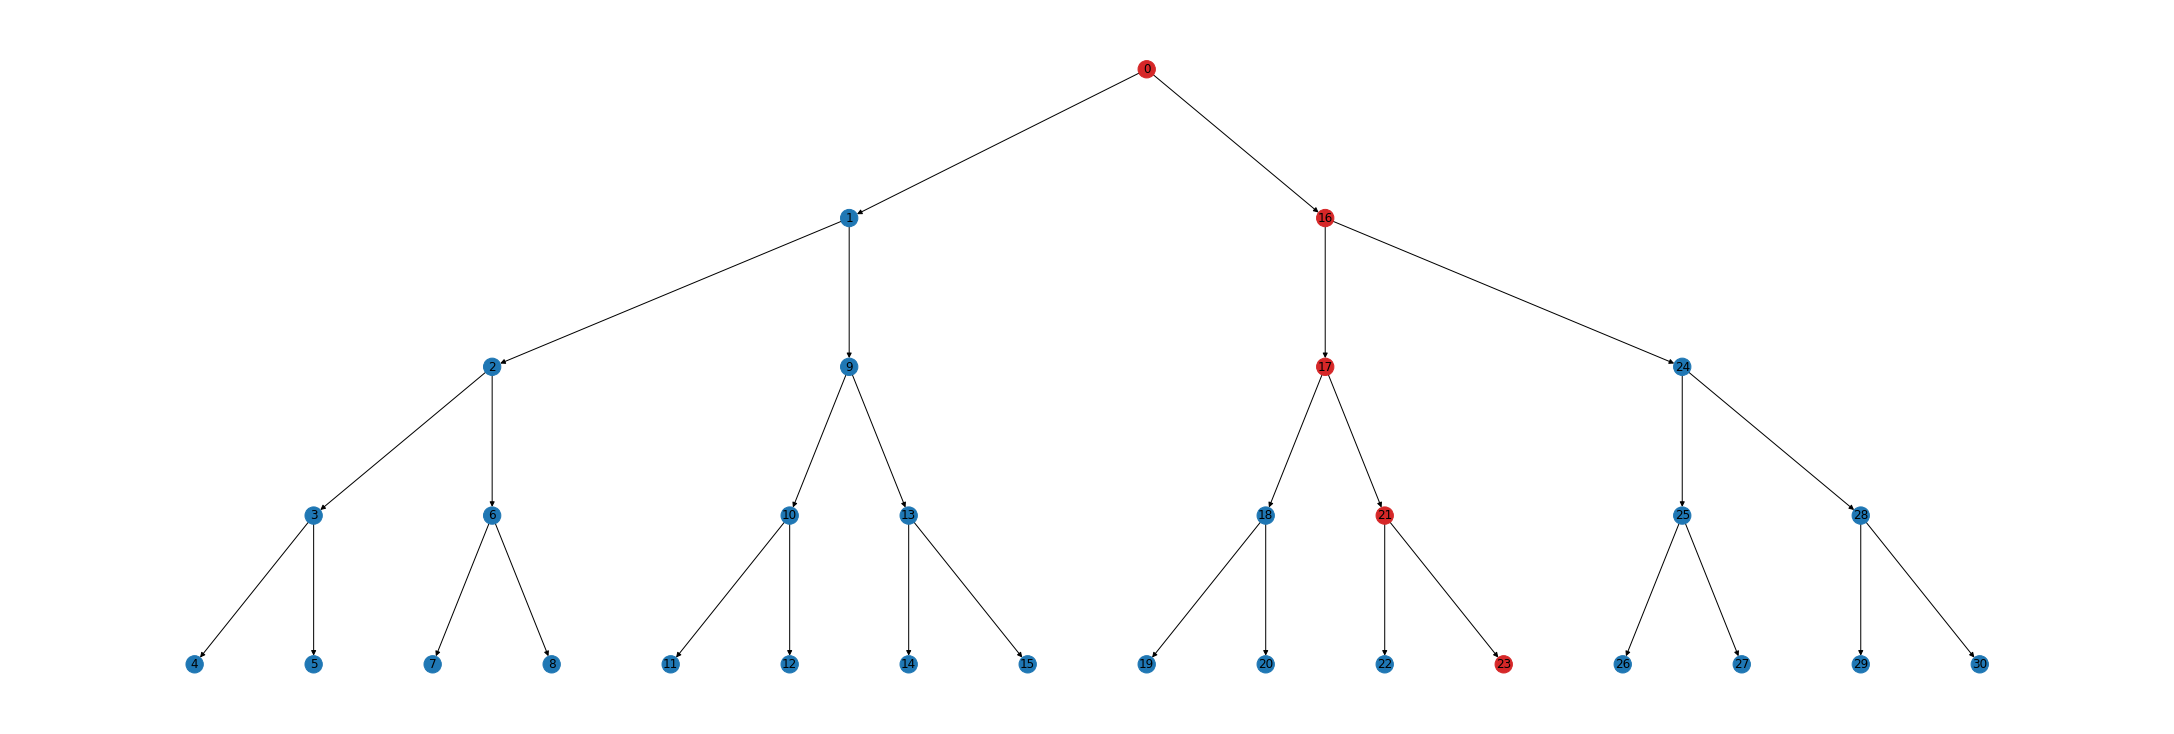


Image embedding as vector: [0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4472136 0.4472136 0.        0.        0.
 0.4472136 0.        0.4472136 0.        0.        0.        0.
 0.        0.        0.       ] 



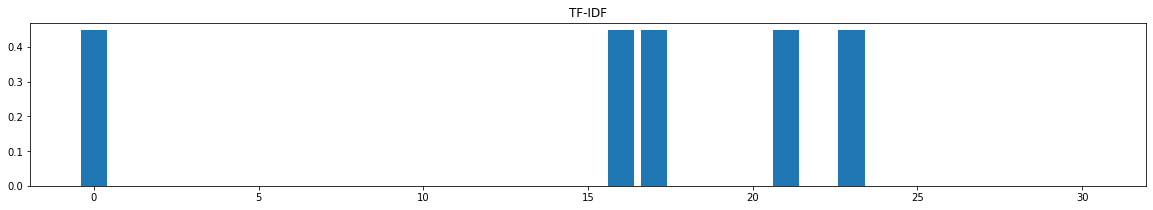

In [22]:
import matplotlib.pyplot as plt

# let's see the images we are encoding
database.dataset.show_image(database.dataset.read_image(image_id + ".jpg"))
print("Image as perceived by us:")
plt.show()

# as a graph
database.propagate(image_id + ".jpg")
database.encode(image_id, return_graph=True)
print("Image embedding as graph:")
plt.show()

# and its corresponding vector
database.propagate(image_id + ".jpg")
embedding = database.encode(image_id)
print("\nImage embedding as vector:", embedding, "\n")
fig = plt.figure(figsize=(20, 3))
plt.bar(np.arange(len(embedding)), embedding)
plt.gca().set_title("TF-IDF")
plt.show()

> ***Action:*** Change the `image_id` above and try encoding a different image

<br>

## **Chapter 4. Scoring and Retrieving (the online phase)**
---


<!-- <div style="margin-left: 230px"> -->
<br>

<div style="margin:auto; float:right; margin-left: 50px; width: 30%">
<img src="images/image_similarity.jpg">
</div>
<br>
    

<p style="color: #a00; font-weight: 700">>> TASK 5</p>

> In this section we are going to learn how to implement the function:
```python
def score(database, image):
    return score
```

The objective of scoring is to compare two images in their embedding form, and return a measure of their **similarity**.

Once the quantization is defined, we wish to determine
the relevance of a database image to the query image based
on how similar the paths down the vocabulary tree are
for the descriptors from the database image and the query
image.

<br>

  

Let's grab two images from the database and get their embeddings


Image 1 embedding: [0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4472136 0.4472136 0.        0.        0.
 0.4472136 0.        0.4472136 0.        0.        0.        0.
 0.        0.        0.       ]


Image 2 embedding: [0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4472136 0.4472136 0.        0.        0.
 0.4472136 0.        0.4472136 0.        0.        0.        0.
 0.        0.        0.       ]


Text(0.5, 1.0, 'Image 2 TF-IDF')

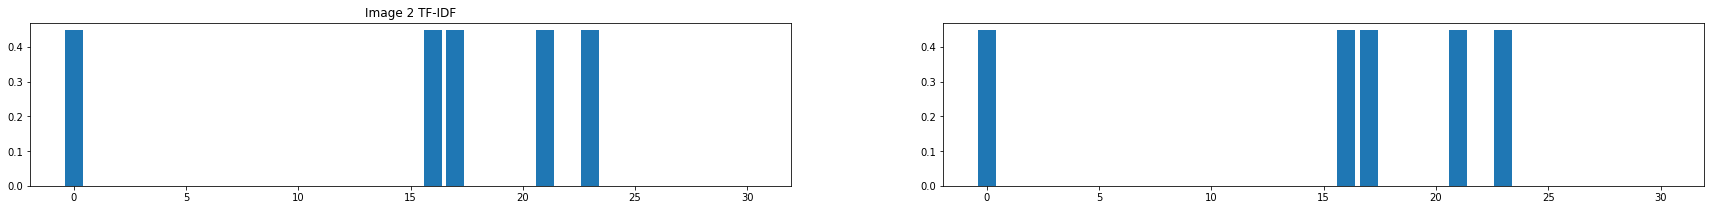

In [23]:
# take two images by using their ids
image_id_1 = "120000"
image_id_2 = "104000"

# let's propagate the images down the tree first
database.propagate(image_id_1 + ".jpg")
database.propagate(image_id_2 + ".jpg")

# and then get their embeddings
em_1 = database.encode(image_id_1)
em_2 = database.encode(image_id_2)

print("\nImage 1 embedding:", em_1)
print("\n\nImage 2 embedding:", em_2)

fig, ax = plt.subplots(1, 2, figsize=(30, 3))
ax[0].bar(np.arange(len(em_1)), em_1)
ax[0].set_title("Image 1 TF-IDF")
ax[1].bar(np.arange(len(em_2)), em_2)
ax[0].set_title("Image 2 TF-IDF")

<br>
We can also look at their graph representations

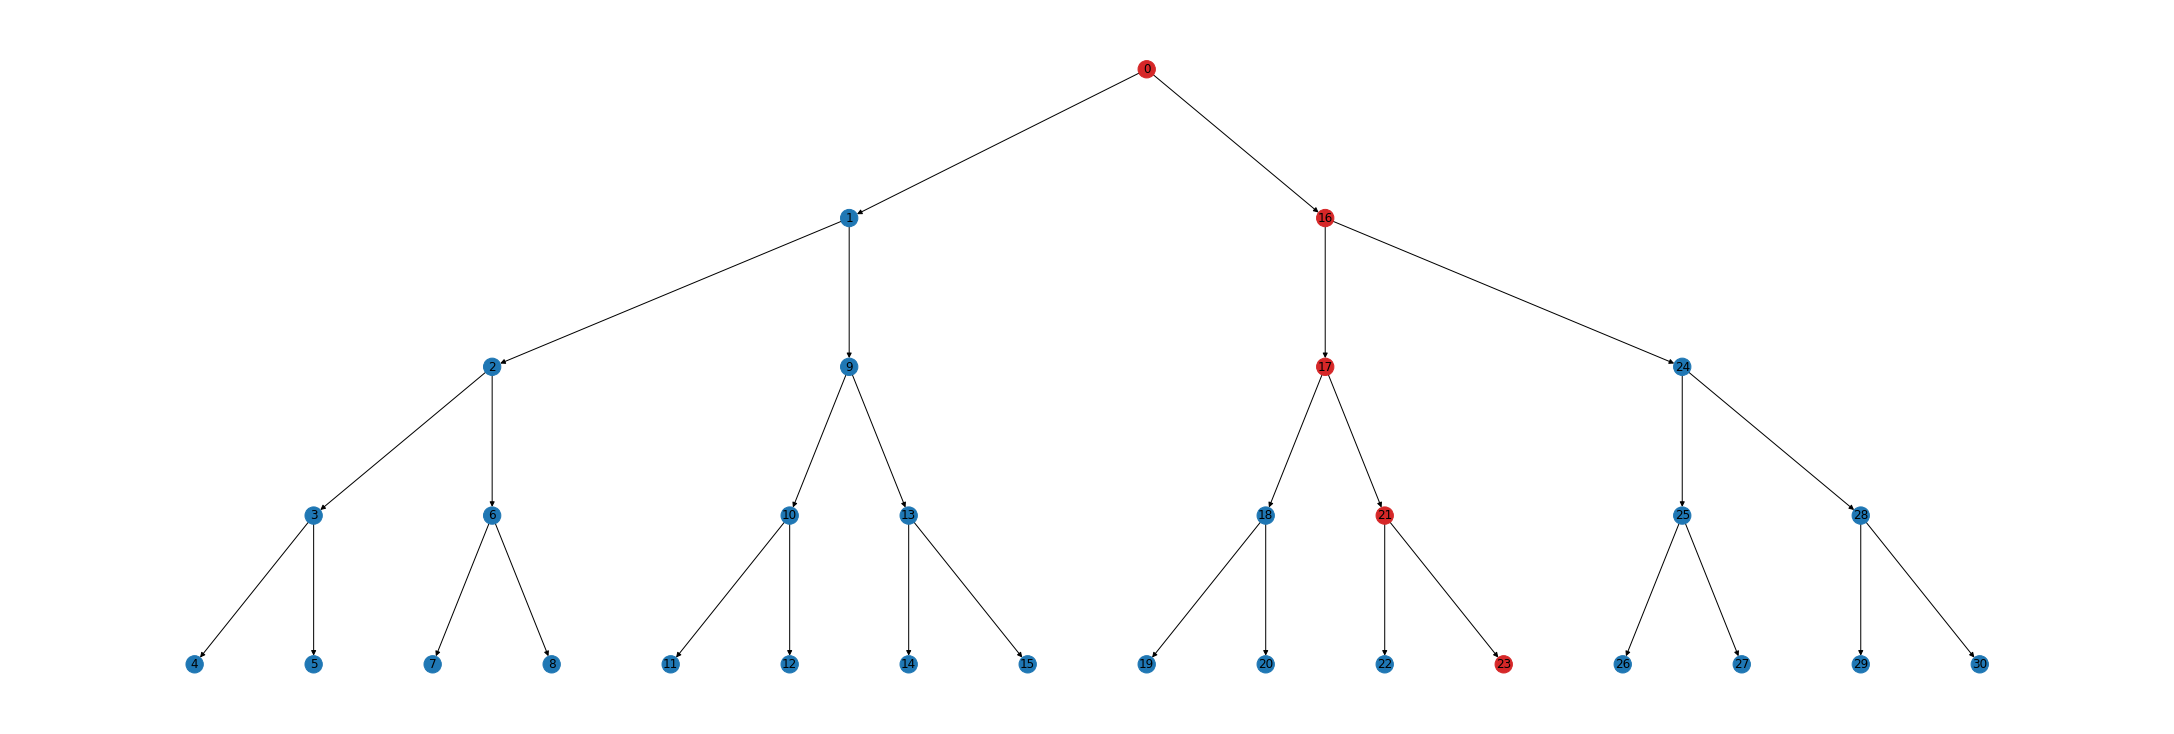

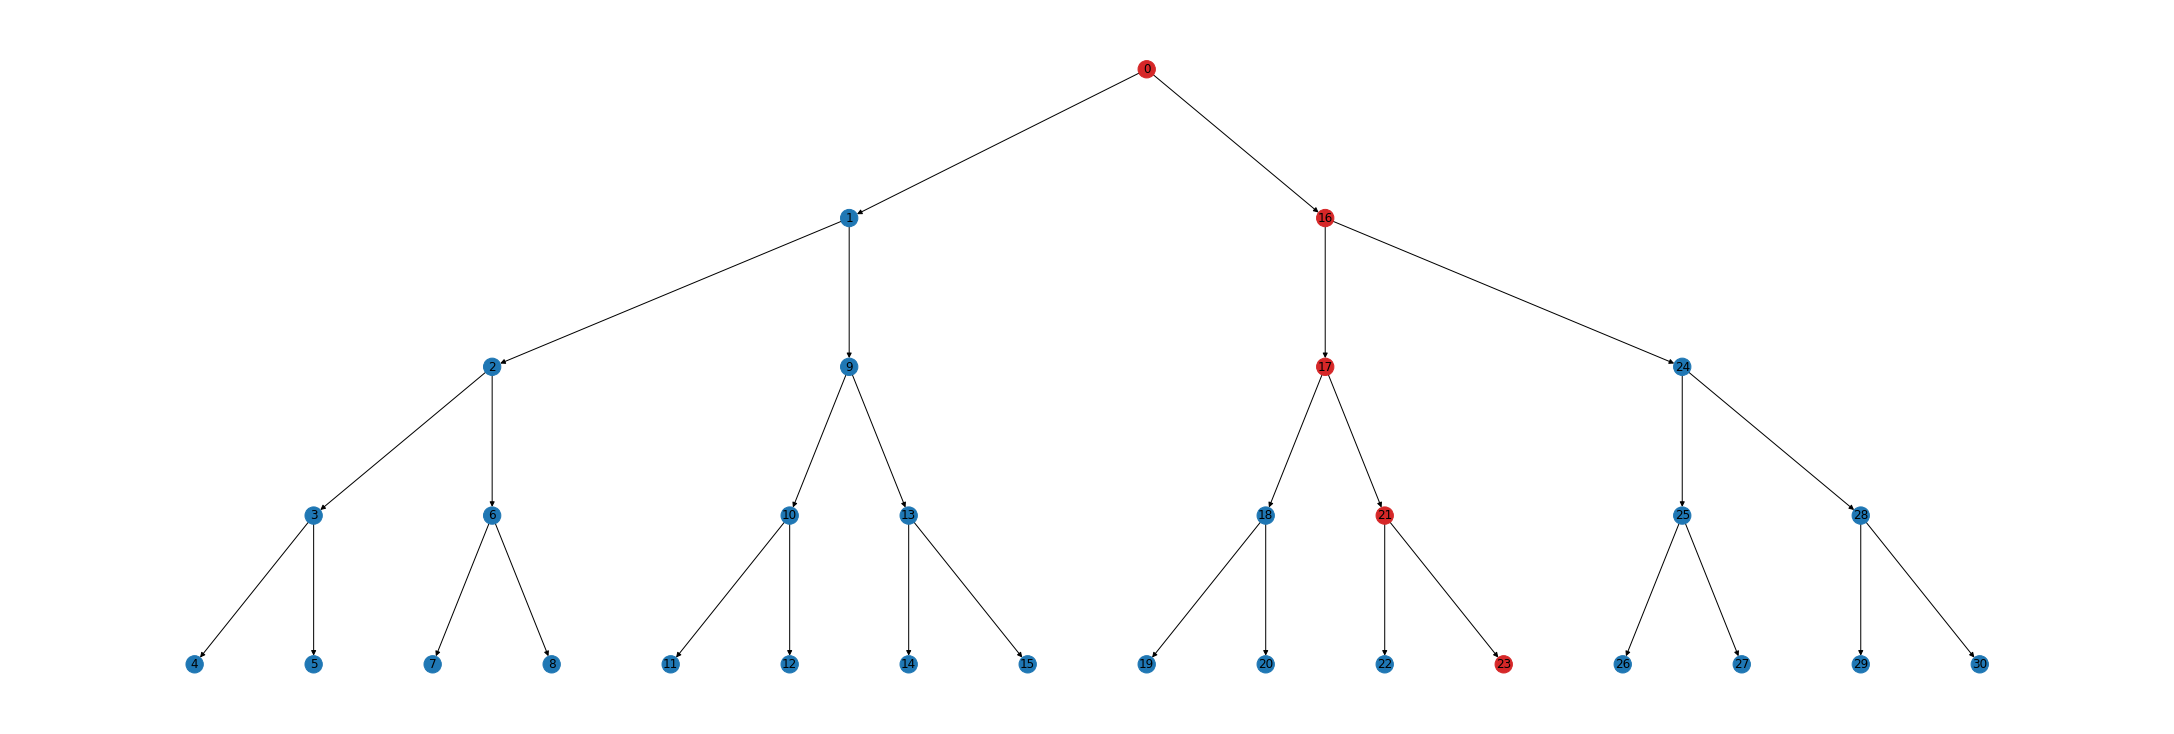

In [24]:
database.encode(image_id_1, return_graph=True)
database.encode(image_id_2, return_graph=True)

<center>
    In this implementation, to measure the score between two images we use <b>L1-norm</b>
    </center>

\begin{align}
MAE(x_1, x_2) = \frac{1}{n}\sum\ | x_{1_i} - x_{2_i} | \\
\end{align}

In [25]:
# let's now try to score the two images
# the function askes for two paths to the two images to score against
image_1 = "data/jpg/104000.jpg"
image_2 = "data/jpg/104002.jpg"

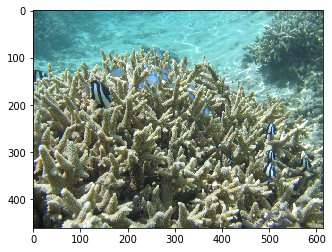

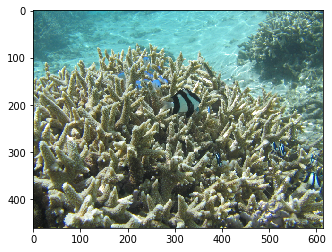

In [26]:
# let's plot them
database.dataset.show_image(database.dataset.read_image(image_1))
plt.show()
database.dataset.show_image(database.dataset.read_image(image_2))

In [27]:
# and now let's score them
score = database.score(image_1, image_2)
print("Score is:", score)

Score is: 1000000.0


/Users/astanziola/Documents/sberbank/cbir.py:189: RuntimeWarning: invalid value encountered in true_divide
  embedding = embedding / np.linalg.norm(embedding, ord=2)  # l2 norm
/Users/astanziola/Documents/sberbank/cbir.py:211: RuntimeWarning: invalid value encountered in double_scalars
  q = q / np.linalg.norm(q)


> ***Action:*** try changing the images above and see how the score changes

<br>

### 4.2 Retrieving an image from the database
---
Here we bring together all the concepts we have illustrated above to build our Large-Scale CBIR system.

In [164]:
# Let's create the database
database = CBIR(root="data/jpg", n_branches=4, depth=4, sift_implementation="alexnet_descriptor")

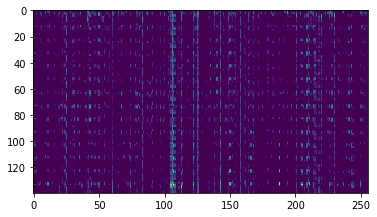

In [169]:
features = database.extract_features("144103.jpg")
plt.imshow(features)

In [170]:
# Now, alet's extract the features
features = database.extract_features()

Extracting features 1491/1491 from image 116701.jpg - ETA: 0.000000sss
527436 features extracted


In [171]:
# We can now train the tree using the extracted features
database.fit(features)

In [172]:
# And we can index all the images
# you can use database.tfidf() to index all the images at once
database.tfidf()


Generating index
Indexing image 1492/1491:  116701.jpg - ETA: 0.000000ss
Calculating weights
Inverted index generated


In [173]:
database.graph.nodes(data="w", default=0)

NodeDataView({0: 0.0, 1: 0.008080852053938674, 2: 0.11276546366440397, 3: 0.361188323665511, 4: 1.0866121446649992, 5: 0.8904700322524123, 6: 0.8921053555931431, 7: 0.6992016894686516, 8: 1.1313350446589772, 9: 1.8911019125603183, 10: 2.0189352840702033, 11: 2.02399858602675, 12: 2.1597078379512853, 13: 0.4784902431230542, 14: 2.20733588694054, 15: 1.040001766223376, 16: 1.1803331306505533, 17: 0.9236956798807328, 18: 0.5433174062023033, 19: 0.7251771758719121, 20: 1.274116092965937, 21: 1.6724127115954888, 22: 4.311470041210748, 23: 0.13554549199622395, 24: 0.40747920747986555, 25: 0.6582177647399622, 26: 0.8302299518750557, 27: 0.7748680225423891, 28: 0.651761964397091, 29: 0.3430667023464937, 30: 0.9036281168299235, 31: 1.291045155066385, 32: 1.2158924326870404, 33: 0.8823332908593506, 34: 0.2614257378852267, 35: 0.9774814092420421, 36: 0.6911371296319211, 37: 0.4981630087217591, 38: 1.7388578110036415, 39: 0.3160254276435289, 40: 1.2113777523325135, 41: 1.7274724887785162, 42: 0.50

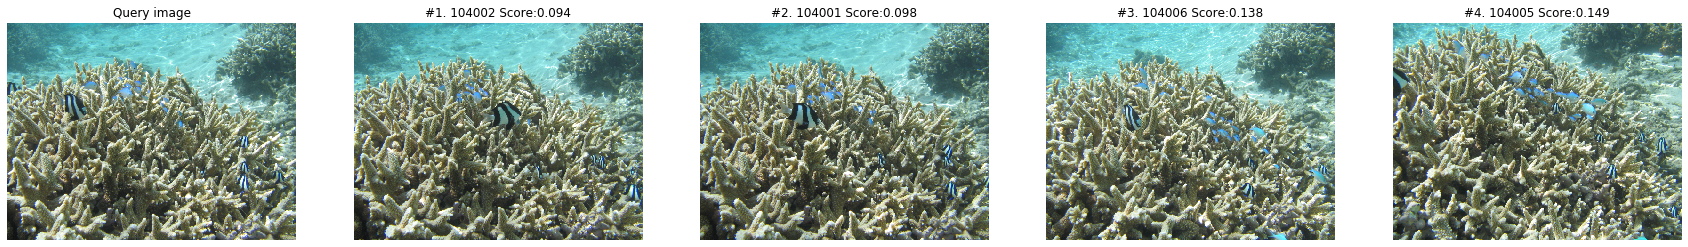

In [174]:
query = "104000.jpg"
scores = database.retrieve(query)
database.show_results(query, scores, figsize=(30, 10))

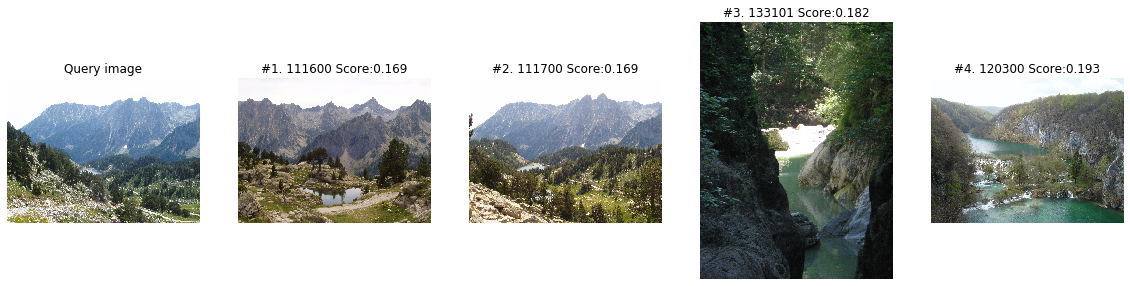

In [189]:
query = random.choice(database_cnn.dataset.all_images)
scores = database.retrieve(query)
database.show_results(query, scores, figsize=(20, 10))

<br>

## **[Optional] Chapter 5. Image encoding with Deep Convolutional Neural Networks**
---

The excercises below this point are not mandatory. They provide a wider picture on how to build an efficient image representation.
We will illustrate how to use a pretrained image classifier to represent the features of an image
- 4.1 Using the output probabilities of a pretrained AlexNet to get the enbedding of an image
- 4.2 Using the one-before-the-last layer of a DCNN as features to propagate in the tree

**5.1 Using the output probabilities of a pretrained AlexNet**

In this optional assignement, we are going to replace the `encode` mapping with the outpu probabilities of *[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)*

In [56]:
# let's download a pretrained version of AlexNet from torchvision
import torch
import torchvision
import matplotlib.pyplot as plt
from cbir import CBIR


In [57]:
database_cnn = CBIR("data/jpg", n_branches=5, depth=5, sift_implementation="alexnet")

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/astanziola/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [58]:
database_cnn.tfidf()


Generating index
Indexing image 1492/1491:  116701.jpg - ETA: 0.000000sss
Calculating weights
Inverted index generated


<BarContainer object of 1000 artists>

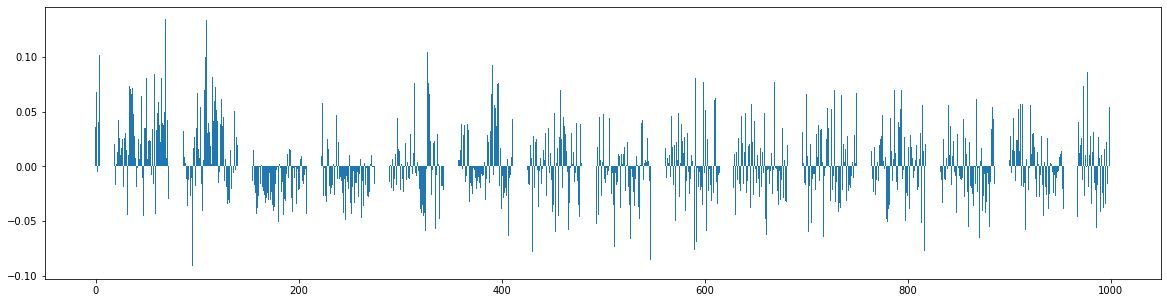

In [59]:
embedding_cnn = database_cnn.encode("104000", return_graph=False)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(embedding_cnn)), embedding_cnn)

In [65]:
import random

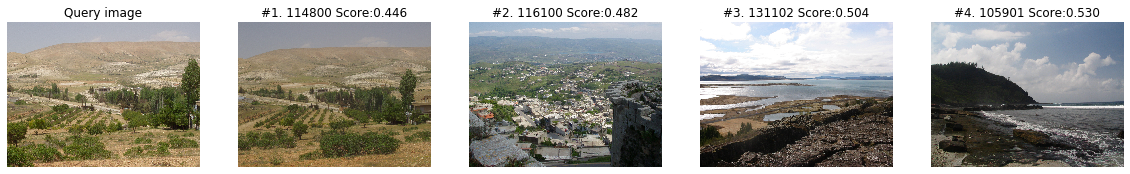

In [81]:
query = random.choice(database_cnn.dataset.all_images)
scores = database_cnn.retrieve(query)
database_cnn.show_results(query, scores, figsize=(20, 10))

<br>

We can compare it with the SIFT+VOCABULARY method below:

In [ ]:
# we create the model as usual
database = CBIR("data/jpg", n_branches=10, depth=6, sift_implementation="ezsift")

In [ ]:
# but this time we load a pretrained vocabulary tree from disk
# we have prepared this for you, as it takes around 30 minutes to train it
database.load()

In [ ]:
scores = database.retrieve(query)
database.show_results(query, scores, figsize=(20, 10))

**5.2 Using the features of a DCNN**

This assignement is for the ones of you more advanced in coding and Deep Learning.  
You can use the code that is in this repository, and replace it with 

In [163]:
database_cnn.dataset.alexnet.features()